# Predictions with Faster RCNN

We need to install coco tools.

In [1]:
#!pip install pycocotools-windows
import pycocotools

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageDraw

import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [3]:
# Define current path
current_path = os.getcwd()

In [4]:
def parse_one_annot(path_to_data_file, filename):
   data = pd.read_csv(path_to_data_file)
   boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
   "xmax", "ymax"]].values
   return boxes_array

In [5]:
class DressDataset(torch.utils.data.Dataset):
  def __init__(self, root, data_file, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = sorted(os.listdir(os.path.join(root, "images")))
    self.path_to_data_file = data_file
  def __getitem__(self, idx):
    # load images and bounding boxes
    img_path = os.path.join(self.root, "images", self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    box_list = parse_one_annot(self.path_to_data_file,self.imgs[idx])
    boxes = torch.as_tensor(box_list, dtype=torch.float32)
    num_objs = len(box_list)
    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    if self.transforms is not None:
      img, target = self.transforms(img, target)
    return img, target
  def __len__(self):
    return len(self.imgs)

In [6]:
def get_model(num_classes):
  # load an object detection model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new on
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
  return model

In [7]:
def get_transform(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

In [8]:
dataset = DressDataset(root= current_path + "/dress_dataset",data_file= current_path+ "/dress_dataset/labels/dress_labels.csv",transforms = get_transform(train=False))

In [9]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4,collate_fn=utils.collate_fn)

In [10]:
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load(current_path + "/model_saved",map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
def predict_box(idx):
    img, _ = dataset[idx]
    label_boxes = np.array(dataset[idx][1]["boxes"])
    
    #put the model in evaluation mode
    loaded_model.eval()
    with torch.no_grad():
        prediction = loaded_model([img])
        image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
        draw = ImageDraw.Draw(image)
    
    # draw groundtruth
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),(label_boxes[elem][2], label_boxes[elem][3])],outline ="green", width =3)
    
    for element in range(len(prediction[0]["boxes"])):
        boxes = prediction[0]["boxes"][element].cpu().numpy()
        score = np.round(prediction[0]["scores"][element].cpu().numpy(),decimals= 4)
        
        
        if score > 0.9:
            draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],outline ="red", width =3)
            draw.text((boxes[0], boxes[1]), text = str(score))
            
        if (score > 0.8 and score <= 0.9) :
            draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],outline ="purple", width =3)
            draw.text((boxes[0], boxes[1]), text = str(score))
    return(image)

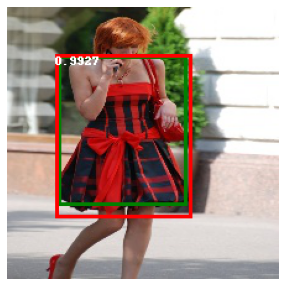

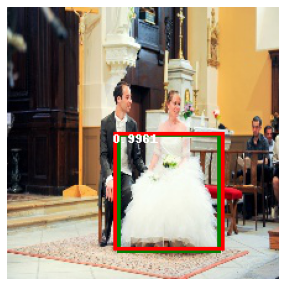

In [12]:
idxs = [569,583]

for i in range(0,len(idxs)):
    plt.figure(i+1,figsize = (5, 5))
    plt.subplot(1, 1, 1)
    plt.axis('off')
    plt.imshow(predict_box(idxs[i]))

plt.show()